In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from soundex import Soundex
from dutch_soundex import DutchSoundex
import seaborn as sns
from helpers import all_intragroup_distances, mean_intergroup_levenshtein, bootstrap_diff

In [2]:
# Load dataset
names = pd.read_csv("familienamen-v2020.01.03.cleaned.csv")

names = names.dropna()

# Keep only complete cases (only cases from the census in 1947 are complete).
names = names.dropna(subset=["achternaam", "counts", "exactified"])

# Remove duplicates and unnecessary columns
names = names.drop_duplicates("achternaam")
names = names.drop(columns=["exactified"])

# Datatyping
names["counts"] = pd.to_numeric(names["counts"])

# Remove prefixes, keep main surname
names["achternaam"] = names["achternaam"].str.split(",").str[0]

In [3]:
# Top 5%
threshold = names["counts"].quantile(0.95)
popular = names.loc[names["counts"] >= threshold].copy()

In [4]:
# Add soundex codes
soundex = Soundex()
dutch_soundex = DutchSoundex()
popular["dutch_soundex"] = popular["achternaam"].apply(lambda x: dutch_soundex.calculate(str(x)))
popular["soundex"] = popular["achternaam"].apply(lambda x: soundex.calculate(str(x)))

In [5]:
dutch_intra = all_intragroup_distances(popular, "dutch_soundex")
soundex_intra = all_intragroup_distances(popular, "soundex")

mean_dutch = np.mean(dutch_intra)
mean_soundex = np.mean(soundex_intra)

In [6]:
mean_inter_dutch = mean_intergroup_levenshtein(popular, "dutch_soundex")
mean_inter_soundex = mean_intergroup_levenshtein(popular, "soundex")

ratio_dutch = mean_dutch / mean_inter_dutch
ratio_soundex = mean_soundex / mean_inter_soundex

In [7]:
ci_lower, ci_upper, p_val = bootstrap_diff(dutch_intra, soundex_intra)

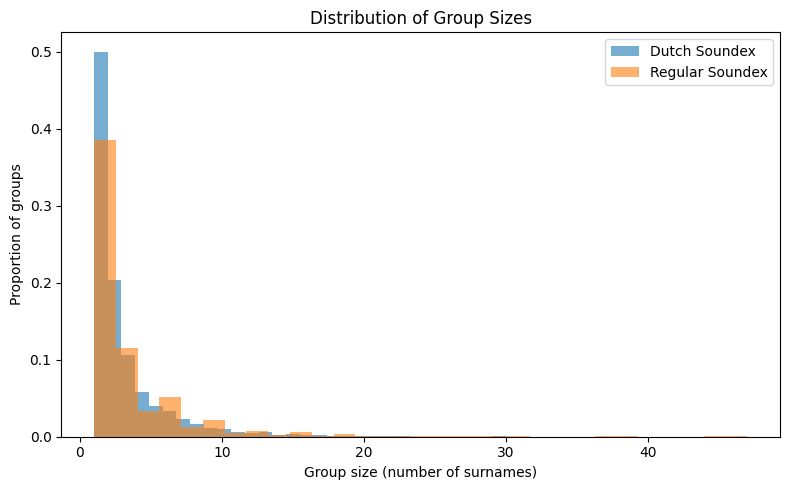

In [17]:
plt.figure(figsize=(8, 5))
popular.groupby("dutch_soundex")["achternaam"].count().plot.hist(bins=30, alpha=0.6, label="Dutch Soundex", density=True)
popular.groupby("soundex")["achternaam"].count().plot.hist(bins=30, alpha=0.6, label="Regular Soundex", density=True)
plt.xlabel("Group size (number of surnames)")
plt.ylabel("Proportion of groups")
plt.title("Distribution of Group Sizes")
plt.legend()
plt.tight_layout()
plt.show()

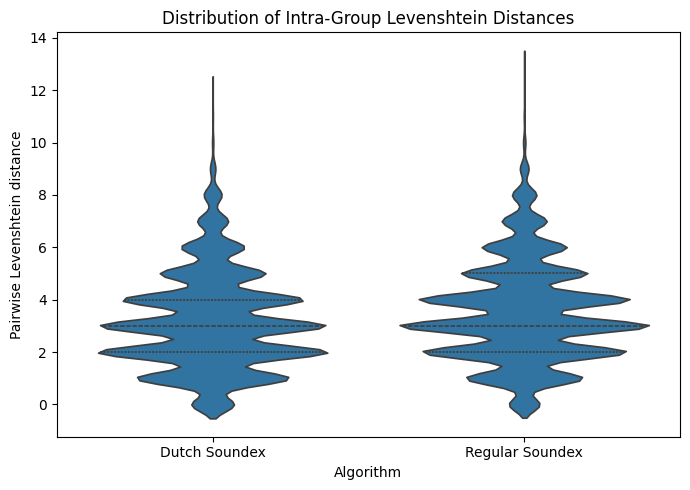

In [9]:
data = [
    pd.DataFrame({"distance": all_intragroup_distances(popular, "dutch_soundex"), "Algorithm": "Dutch Soundex"}),
    pd.DataFrame({"distance": all_intragroup_distances(popular, "soundex"), "Algorithm": "Regular Soundex"}),
]
dist_df = pd.concat(data)

plt.figure(figsize=(7, 5))
sns.violinplot(x="Algorithm", y="distance", data=dist_df, inner="quartile")
plt.title("Distribution of Intra-Group Levenshtein Distances")
plt.ylabel("Pairwise Levenshtein distance")
plt.tight_layout()
plt.show()

In [10]:
table = pd.DataFrame({
    "": ["Dutch Soundex", "Regular Soundex"],
    "Mean Intra-group\nLevenshtein": [mean_dutch, mean_soundex],
    "Mean Inter-group\nLevenshtein": [mean_inter_dutch, mean_inter_soundex],
    "Intra/Inter Ratio": [ratio_dutch, ratio_soundex],
}).set_index("")

print("\n=== Clustering Performance Table ===\n")
print(table.to_markdown(floatfmt=".3f"))

print("\nDifference in mean intra-group distance (Dutch - Regular): "
      f"{mean_dutch - mean_soundex:.3f} "
      f"(95% CI: {ci_lower:.3f} to {ci_upper:.3f}, bootstrap p={p_val:.4f})")

if p_val < 0.05:
    print("\nResult: The difference is statistically significant (p < 0.05).")
else:
    print("\nResult: The difference is not statistically significant (p >= 0.05).")

num_names = popular["achternaam"].nunique()
num_groups_dutch = popular["dutch_soundex"].nunique()
num_groups_soundex = popular["soundex"].nunique()
print(f"\nNumber of names: {num_names}")
print(f"Number of Dutch Soundex groups: {num_groups_dutch}")
print(f"Number of Regular Soundex groups: {num_groups_soundex}")




=== Clustering Performance Table ===

|                 |   Mean Intra-group |   Mean Inter-group |   Intra/Inter Ratio |
|                 |        Levenshtein |        Levenshtein |                     |
|:----------------|-------------------:|-------------------:|--------------------:|
| Dutch Soundex   |              3.168 |              6.692 |               0.473 |
| Regular Soundex |              3.512 |              6.691 |               0.525 |

Difference in mean intra-group distance (Dutch - Regular): -0.344 (95% CI: -0.382 to -0.306, bootstrap p=0.0000)

Result: The difference is statistically significant (p < 0.05).

Number of names: 5695
Number of Dutch Soundex groups: 2255
Number of Regular Soundex groups: 1786
